Using cache found in C:\Users\zixua/.cache\torch\hub\saahiluppal_catr_master


The input image is:


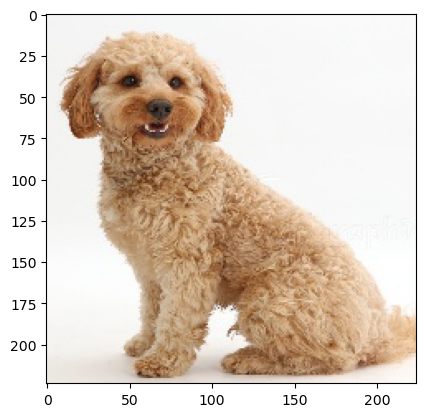

The generated captions are:
A yellow sitting cockapoo dog in the blank background
A standing dog
A yellow sitting cockapoo dog
A sitting cockapoo dog
The average BLEU score is:
Average BLEU score for 4 generated captions is 0.7763888888888888




In [20]:
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F
from transformers import BertTokenizer
from PIL import Image
import argparse
import numpy as np
from models import caption
from datasets import coco, utils
from configuration import Config
import os
import warnings
from nltk.translate.bleu_score import sentence_bleu
warnings.filterwarnings("ignore") 
# parser = argparse.ArgumentParser(description='Image Captioning')
# parser.add_argument('--path', type=str, help='path to image', required=True)
# parser.add_argument('--v', type=str, help='version', default='v3')
# parser.add_argument('--checkpoint', type=str, help='checkpoint path', default=None)
# args = parser.parse_args()
# image_path = args.path
# version = args.v
# checkpoint_path = args.checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
version = 'v3'

config = Config()

if version == 'v1':
    model = torch.hub.load('saahiluppal/catr', 'v1', pretrained=True)
elif version == 'v2':
    model = torch.hub.load('saahiluppal/catr', 'v2', pretrained=True)
elif version == 'v3':
    model = torch.hub.load('saahiluppal/catr', 'v3', pretrained=True)
    torch.save(model.state_dict(), './saved_checkpoints/pretrained_model.pt')
    model.load_state_dict(torch.load('./saved_checkpoints/best_CPTR.pt'))
else:
    print("Checking for checkpoint.")
    if checkpoint_path is None:
        raise NotImplementedError('No model to chose from!')
    else:
        if not os.path.exists(checkpoint_path):
            raise NotImplementedError('Give valid checkpoint path')
        print("Found checkpoint! Loading!")
        model,_ = caption.build_model(config)
        print("Loading Checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)

def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

@torch.no_grad()
def predict(image_path, devic, temperature=1.0, top_p=None, top_k=None):
    if top_p is not None and top_k is not None:
        print('Only one sampling approach is allowed')
        return
    if top_p is None and top_k is None:
        print('You must select a sampling approach')
        return
    
    image = Image.open(image_path)
    image = coco.val_transform(image)
    image = image.unsqueeze(0)
    generation_prob = []
    #caption.shape(1, max_length)
    caption, cap_mask = create_caption_and_mask(
        start_token, config.max_position_embeddings)    
    model.eval()
    model.to(device)
    for i in range(config.max_position_embeddings - 1):
        #caption, cap_mask = (1,128) 128 is max_length
        #prediction.shape = torch.Size([1, 128, 30522])
        #image.shape = (1,3,299,299)
        predictions = model(image.to(device), caption.to(device), cap_mask.to(device))
        predictions = predictions[:, i, :] / temperature
        probs = F.softmax(predictions, dim=-1)
        if top_k is not None:
            idx_next_prob, idx_next = torch.topk(probs, k=top_k, dim=-1)
            
        if top_p is not None:
            top_k = 1
            idx_next_prob, idx_next = torch.topk(probs, k=top_k, dim=-1)
            while idx_next_prob.detach().cpu().sum().item() < top_p:
                top_k += 1
                idx_next_prob, idx_next = torch.topk(probs, k=top_k, dim=-1)
        
        idx_next_prob, idx_next = idx_next_prob[0].detach().cpu(), idx_next[0].detach().cpu()
        sum_prob = idx_next_prob.sum().item()
        idx_next_prob = [prob_i/sum_prob for prob_i in idx_next_prob.tolist()]
        idx_next_prob[-1] = 1 - sum(idx_next_prob[:-1]) 
        if idx_next_prob[-1] < 0:
            idx_next_prob[-1] = 0
            index = -1
            while sum(idx_next_prob[:index]) > 1:
                idx_next_prob[index-1] = 0
                index -= 1
            idx_next_prob [index] = 1 - sum(idx_next_prob[:index])

        select_token = np.random.choice(idx_next.tolist(), 1, p=idx_next_prob)  
        for token, token_prob in zip(idx_next, idx_next_prob):
            if token == select_token[0]:
                generation_prob.append(token_prob)    
                         
        predicted_id = torch.argmax(predictions, axis=-1)
        if select_token[0] == 102 or select_token[0] == 1012:
            return caption, generation_prob

        caption[:, i+1] = select_token[0]
        cap_mask[:, i+1] = False
        
    return caption, generation_prob

def generate_n_captions(image_path, num_examples, reference):
    image = Image.open(image_path)
    print('The input image is:')
    plt.imshow(image, vmin=0, vmax=255)
    plt.show()
    all_generation_word = []
    all_generation_prob = []
    reverse_replace_dict = {'parrot':'Cockapoo', 'dalmatian':'Dalmation', 'bluebonnet':'Bluetick', 'pere':'Perenees', 'goren':'Groenendael', 'shih':'Shih-Tzu', 'shar':'Shar_Pei', 'komon':'Komondor'}
    print('The generated captions are:')
    for _ in range(num_examples):
        caption, generation_prob = predict(image_path, device, temperature=1.0, top_p=None, top_k=3)
        result = tokenizer.decode(caption[0].tolist(), skip_special_tokens=True)
        sting_list = result.split()
        combined_string = ''
        for i, word in enumerate (sting_list):
            if word in reverse_replace_dict.keys():
                sting_list[i] = reverse_replace_dict[word]
            if i != 0:
                combined_string += ' '
            combined_string += sting_list[i]    

        #result = tokenizer.decode(output[0], skip_special_tokens=True)
        print(combined_string.capitalize())
        all_generation_word.append(sting_list)
        all_generation_prob.append(generation_prob)
    print('The average BLEU score is:')
    BLEU_score = []
    for generation_word in all_generation_word:
        BLEU_score.append(sentence_bleu(reference, generation_word, weights=[1]))

    print('Average BLEU score for {} generated captions is {}'.format(num_examples, sum(BLEU_score)/len(BLEU_score)))  
    print('\n')
image_path = '../All_Data/valid/Cockapoo/1.jpg'
num_examples = 4
reference = [
            'a sitting dog'.split(),
            'a sitting cockapoo dog'.split(),
            'a yellow sitting cockapoo dog'.split(),
            'a yellow sitting cockapoo dog in the blank background'.split()
            ]
generate_n_captions(image_path, num_examples, reference)


The input image is:


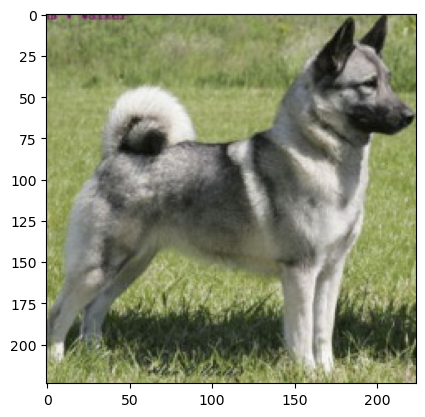

The generated captions are:
A standing elk hound dog
A standing elk hound dog
A white and black standing elk hound dog on the grass
A yellow and black standing elk hound dog on the grass
The average BLEU score is:
Average BLEU score for 4 generated captions is 0.9772727272727273




In [8]:
image_path = '../All_Data/valid/Elk Hound/2.jpg'
num_examples = 4
reference = [
            'a standing dog'.split(),
            'a standing elk hound dog'.split(),
            'a black and white standing elk hound dog'.split(),
            'a black and white standing elk hound dog on the grass'.split()
            ]
generate_n_captions(image_path, num_examples, reference)

In [3]:
reference = [
            'a sitting dog',
            'a sitting cockapoo dog',
            'a yellow sitting cockapoo dog',
            'a yellow sitting cockapoo dog in the blank background'
            ]
for ref in reference:
    print(ref)

a sitting dog
a sitting cockapoo dog
a yellow sitting cockapoo dog
a yellow sitting cockapoo dog in the blank background


In [4]:
reference = [
            'a standing dog',
            'a standing elk hound dog',
            'a black and white standing elk hound dog',
            'a black and white standing elk hound dog on the grass'
            ]
for ref in reference:
    print(ref)

a standing dog
a standing elk hound dog
a black and white standing elk hound dog
a black and white standing elk hound dog on the grass
